In [1]:
#Run cell to mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
#import necessary packages

#our workhorses
import numpy as np
import pandas as pd
import scipy

#to visualize
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#style params for figures
sns.set(font_scale = 2)
plt.style.use('seaborn-white')
plt.rc("axes", labelweight="bold")
from IPython.display import display, HTML

#to load files
import os
import sys
import h5py
import pickle


#append repo folder to search path
sys.path.append('/content/drive/MyDrive/limb-position-EMG-Repo/')
from utils import *

from sklearn.model_selection import KFold

In [38]:
import tensorflow

In [39]:
print(tensorflow.__version__)

2.5.0


In [3]:
def get_rnn_model(input_shape, n_outputs, n_grus = 24, n_dense_pre = 0, n_dense_post = 0, drop_prob = 0.5, activation = 'tanh', mask_value = -100):
    """
    Create simple RNN model
    
    Args:
        input_shape
        n_outputs: number of output classes
        mask_value: value indicating which timepoints to mask out
            
    Returns:
        model
    """
    
    #define model architecture
    X_input = Input(shape = input_shape)
    X = Masking(mask_value=mask_value)(X_input)
    for n in range(n_dense_pre):
        X = TimeDistributed(Dense(input_shape[1],activation = activation))(X)
        X = Dropout(drop_prob)(X)
    X = GRU(n_grus, return_sequences= True, stateful = False)(X)
    X = Dropout(drop_prob)(X)
    for n in range(n_dense_post):
        X = TimeDistributed(Dense(n_grus,activation = activation))(X)
        X = Dropout(drop_prob)(X)
    X = TimeDistributed(Dense(n_outputs,activation = 'softmax'))(X)
    model = Model(inputs = X_input, outputs = X)
    return model

def RNN_on_labeled_data(feature_matrix, target_labels, window_tstamps, block_labels, model, n_splits = 4,\
                       verbose = 0, epochs = 40, batch_size = 2, permute = False):
    """
    Train and evaluate RNN model on labeled data
    
    Args:
        feature_matrix: 2D nuumpy array with data, dimensions [features, samples]
        window_blocks: 1D numpy array indicating block of provenance for input segment values
        train: Boolean indicating whether the input data is training data
        scaler: StandardScaler to transform data
        magic_value: integer indicating value with which to pad samples
            
    Returns:
        train_f1_scores: training scores for each split
        test_f1_scores: test scores for each split


    """
    
    # transpose data
    #feature_matrix = feature_matrix.T
    
    #initialize empty array
    train_f1_scores = np.empty((n_splits,))
    test_f1_scores = np.empty((n_splits,))


    #get block_ids and corresponding classes in block. there are the units over which we will do train/test split
    blocks = np.array([k for k,g in groupby(block_labels)])
    classes = np.array([k for k,g in groupby(target_labels) if k!=0])
    
    #permute class labels, if indicated
    if permute:
        #using indexing tricks to have this work out
        classes_perm = np.random.permutation(classes)
        target_labels_shuffled = np.empty((0,))
        for i,b in enumerate(blocks):
            idxs = np.where(block_labels==b)[0]
            target_labels_shuffled = np.hstack((target_labels_shuffled,classes_perm[i]*np.ones((idxs.size,))))
        target_labels = target_labels_shuffled
        classes = classes_perm
     
    
    #stratify split to retain ratio of class labels
    skf = StratifiedKFold(n_splits=n_splits,shuffle = True)
    print(block_labels.shape)
    print(target_labels.shape)
    print(blocks.shape,classes.shape)

    #systematically use one fold of the data as a held-out test set
    for split_count, (blocks_train_idxs, blocks_test_idxs) in enumerate(skf.split(blocks, classes)):
        print('Split Count: %i'% (split_count+1))

        #get train and test indices
        blocks_train = blocks[blocks_train_idxs]
        blocks_test = blocks[blocks_test_idxs]
        train_idxs =np.where(np.isin(block_labels,blocks_train))[0]
        test_idxs =np.where(np.isin(block_labels,blocks_test))[0]

        # select training data and pad to get an array where each sample has same number of timesteps
        X_train = feature_matrix[:,train_idxs]
        y_train = target_labels[train_idxs]
        #one-hot encoding of class labels
        y_train = to_categorical(y_train-np.min(y_train))
        #get block labels of given samples
        win_blocks_train = block_labels[train_idxs]

        #get cube
        X_train_cube, Y_train_cube, scaler = get_data_cube(X_train, y_train,win_blocks_train, train = True, magic_value = -100)
        print(X_train_cube.shape, Y_train_cube.shape)

        # select test data and pad to get an array where each sample has same number of timesteps
        X_test = feature_matrix[:,test_idxs]
        y_test = target_labels[test_idxs]
        #one-hot encoding of class labels
        y_test = to_categorical(y_test-np.min(y_test))
        #get block labels of given samples
        win_blocks_test = block_labels[test_idxs]
        #get data cube
        X_test_cube, Y_test_cube, scaler = get_data_cube(X_test, y_test, win_blocks_test, train = False, scaler = scaler, magic_value = -100)
        print(X_test_cube.shape, Y_test_cube.shape)

        n_timesteps, n_features, n_outputs = X_train_cube.shape[1], X_train_cube.shape[2], Y_test_cube.shape[2]

        # #setting timestep dimension to None 
        # model = many_to_many_model((None,n_features),n_outputs,mask_value = -100)
        # model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        # #model.summary

        print('Training Model')
        # fit network
        model.fit(X_train_cube, Y_train_cube, epochs=epochs, batch_size=batch_size, verbose=verbose)

        print('Evaluating Model')
        #evaluate model on train and test data
        train_f1_scores[split_count] = get_RNN_f1(X_train_cube, Y_train_cube, model)
        test_f1_scores[split_count] = get_RNN_f1(X_test_cube, Y_test_cube, model)

    return train_f1_scores, test_f1_scores

def RNN_xsubject_joint_data(feature_matrix, target_labels, sub_labels, block_labels, model_dict, n_splits = 4,\
                       verbose = 0, epochs = 40, batch_size = 2, validation_split = 0.1, permute = False):
    
    #subjects in list. there are the units over which we will do train/test split
    subs = np.unique(sub_labels)
    #permute class labels, if indicated
    if permute:
        #permute labels within each subject
        class_perm = np.empty((0,))
        for s in subs:
            sub_idxs = np.where(sub_labels==s)[0]
            blocks_sub = block_labels[sub_idxs]
            class_sub = target_labels[sub_idxs]

            class_sub_perm, dummy = permute_class_blocks(blocks_sub, class_sub)
            class_perm = np.hstack((class_perm, class_sub_perm))
        target_labels = class_perm.copy()

    #initialize object for k-fold cross-validation
    kf = KFold(n_splits=n_splits,shuffle = True)
    #initialize empty array
    train_f1_scores = np.empty((n_splits,))
    test_f1_scores = np.empty((n_splits,))
    train_history = dict()
    train_history['loss'] = np.empty((0,0))
    train_history['val_loss'] = np.empty((0,0))

    for split_count, (subs_train_idxs, subs_test_idxs) in enumerate(kf.split(subs)):
        print('Split Count: %i'% (split_count+1))


        #get train and test indices
        train_subs = subs[subs_train_idxs]
        test_subs = subs[subs_test_idxs]
        train_idxs = np.where(np.isin(sub_labels,train_subs, invert = False))[0]
        test_idxs = np.where(np.isin(sub_labels,test_subs, invert = False))[0]

        # select training data and pad to get an array where each sample has same number of timesteps
        X_train = feature_matrix[:,train_idxs]
        y_train = target_labels[train_idxs]
        #one-hot encoding of class labels
        y_train = to_categorical(y_train-np.min(y_train))
        #get block labels of given samples
        win_blocks_train = block_labels[train_idxs]

        #get cube
        X_train_cube, Y_train_cube, scaler = get_data_cube(X_train, y_train,win_blocks_train, train = True, magic_value = -100)
        print(X_train_cube.shape, Y_train_cube.shape)

        # select test data and pad to get an array where each sample has same number of timesteps
        X_test = feature_matrix[:,test_idxs]
        y_test = target_labels[test_idxs]
        #one-hot encoding of class labels
        y_test = to_categorical(y_test-np.min(y_test))
        #get block labels of given samples
        win_blocks_test = block_labels[test_idxs]
        #get data cube
        X_test_cube, Y_test_cube, scaler = get_data_cube(X_test, y_test, win_blocks_test, train = False, scaler = scaler, magic_value = -100)
        print(X_test_cube.shape, Y_test_cube.shape)
        n_timesteps, n_features, n_outputs = X_train_cube.shape[1], X_train_cube.shape[2], Y_test_cube.shape[2]

        # Define model architecture
        # setting timestep dimension to None 
        model = get_rnn_model((None,n_features), n_outputs, n_grus = model_dict['n_grus'], n_dense_pre = model_dict['n_dense_pre'],\
                            n_dense_post =  model_dict['n_dense_post'], activation = model_dict['activation'],\
                            mask_value = -100)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        print('Training Model')
        # fit network
        history = model.fit(X_train_cube, Y_train_cube, validation_split = validation_split, epochs=epochs, batch_size=batch_size, verbose=verbose)

        print('Evaluating Model')
        #evaluate model on train and test data
        train_f1_scores[split_count] = get_RNN_f1(X_train_cube, Y_train_cube, model)
        test_f1_scores[split_count] = get_RNN_f1(X_test_cube, Y_test_cube, model)

        #append history
        train_history['loss'] = np.vstack((train_history['loss'],history.history['loss'])) if train_history['loss'].size else np.array(history.history['loss'])
        train_history['val_loss'] = np.vstack((train_history['val_loss'],history.history['val_loss'])) if train_history['val_loss'].size else np.array(history.history['val_loss'])

    return train_f1_scores, test_f1_scores, train_history


In [13]:
def RNN_xsubject_joint_data_model(feature_matrix, target_labels, sub_labels, block_labels, model_dict, n_splits = 4,\
                       verbose = 0, epochs = 40, batch_size = 2, validation_split = 0.1, permute = False):
    
    #subjects in list. there are the units over which we will do train/test split
    subs = np.unique(sub_labels)
    #permute class labels, if indicated
    if permute:
        #permute labels within each subject
        class_perm = np.empty((0,))
        for s in subs:
            sub_idxs = np.where(sub_labels==s)[0]
            blocks_sub = block_labels[sub_idxs]
            class_sub = target_labels[sub_idxs]

            class_sub_perm, dummy = permute_class_blocks(blocks_sub, class_sub)
            class_perm = np.hstack((class_perm, class_sub_perm))
        target_labels = class_perm.copy()


    #get train
    train_subs = subs
    train_idxs = np.where(np.isin(sub_labels,train_subs, invert = False))[0]


    # select training data and pad to get an array where each sample has same number of timesteps
    X_train = feature_matrix[:,train_idxs]
    y_train = target_labels[train_idxs]
    #one-hot encoding of class labels
    y_train = to_categorical(y_train-np.min(y_train))
    #get block labels of given samples
    win_blocks_train = block_labels[train_idxs]

    #get cube
    X_train_cube, Y_train_cube, scaler = get_data_cube(X_train, y_train,win_blocks_train, train = True, magic_value = -100)
    print(X_train_cube.shape, Y_train_cube.shape)
    n_timesteps, n_features, n_outputs = X_train_cube.shape[1], X_train_cube.shape[2], Y_train_cube.shape[2]

    # Define model architecture
    # setting timestep dimension to None 
    model = get_rnn_model((None,n_features), n_outputs, n_grus = model_dict['n_grus'], n_dense_pre = model_dict['n_dense_pre'],\
                        n_dense_post =  model_dict['n_dense_post'], activation = model_dict['activation'],\
                        mask_value = -100)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print('Training Model')
    # fit network
    history = model.fit(X_train_cube, Y_train_cube, validation_split = validation_split, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    train_f1 = get_RNN_f1(X_train_cube, Y_train_cube, model)

    return model, train_f1, scaler, history


In [4]:
#define hyper params for each model
model_dict = {1:{'n_grus':24, 'n_dense_pre':0, 'n_dense_post': 0, 'activation':''},\
              2:{'n_grus':24, 'n_dense_pre':1, 'n_dense_post': 0, 'activation':'tanh'},\
              3:{'n_grus':24, 'n_dense_pre':2, 'n_dense_post': 0, 'activation':'tanh'},\
              4:{'n_grus':24, 'n_dense_pre':3, 'n_dense_post': 0, 'activation':'tanh'},\
              5:{'n_grus':24, 'n_dense_pre':1, 'n_dense_post': 0, 'activation':'relu'},\
              6:{'n_grus':24, 'n_dense_pre':2, 'n_dense_post': 0, 'activation':'relu'},\
              7:{'n_grus':24, 'n_dense_pre':3, 'n_dense_post': 0, 'activation':'relu'},\
              8:{'n_grus':24, 'n_dense_pre':0, 'n_dense_post': 1, 'activation':'tanh'},\
              9:{'n_grus':24, 'n_dense_pre':0, 'n_dense_post': 2, 'activation':'tanh'},\
              10:{'n_grus':24, 'n_dense_pre':0, 'n_dense_post': 3, 'activation':'tanh'},\
              11:{'n_grus':24, 'n_dense_pre':0, 'n_dense_post': 1, 'activation':'relu'},\
              12:{'n_grus':24, 'n_dense_pre':0, 'n_dense_post': 2, 'activation':'relu'},\
              13:{'n_grus':24, 'n_dense_pre':0, 'n_dense_post': 3, 'activation':'relu'},\
              14:{'n_grus':24, 'n_dense_pre':2, 'n_dense_post': 2, 'activation':'tanh'},\
              15:{'n_grus':24, 'n_dense_pre':2, 'n_dense_post': 2, 'activation':'relu'},\
              }


1

In [5]:
#define where the data files are located
data_folder = '/content/drive/MyDrive/limb-position-EMG-Repo/EMG_data/'

nsubjects = 36

#randomly-selected subjects to use as hold-out test data 
test_subjects = [17, 23,  7,  8,  3]

# User-defined parameters
lo_freq = 20 #lower bound of bandpass filter
hi_freq = 450 #upper bound of bandpass filter

win_size = 100 #define window size over which to compute time-domain features
step = win_size #keeping this parameter in case we want to re-run later with some overlap

#excluded labels
exclude = [0,7]

In [6]:
#intialize empty lists
feature_matrix_all = np.empty((0,0))
target_labels_all = np.empty((0,))
window_tstamps_all = np.empty((0,))
block_labels_all  = np.empty((0,))
subject_id_all = np.empty((0,))
block_count = 0

for subject_id in range(1,nsubjects+1):
    if subject_id not in test_subjects:
        subject_folder = os.path.join(data_folder,'%02d'%(subject_id))
        print('=======================')
        print(subject_folder)

        # Process data and get features 
        #get features across segments and corresponding info
        feature_matrix, target_labels, window_tstamps, \
        block_labels, series_labels = get_subject_data_for_classification(subject_folder, lo_freq, hi_freq, \
                                                                        win_size, step)

        #prevent repeat of block labels by increasing block count
        block_labels = block_labels+block_count
        block_count = np.max([block_count, np.max(block_labels)])
        #exclude indicated samples
        in_samples = np.where(np.isin(target_labels,exclude, invert = True))[0]
        feature_matrix_in = feature_matrix[in_samples,:]
        target_labels_in = target_labels[in_samples]
        window_tstamps_in = window_tstamps[in_samples]
        block_labels_in = block_labels[in_samples]
        # concatenate lists
        feature_matrix_all = np.vstack((feature_matrix_all,feature_matrix_in)) if feature_matrix_all.size else feature_matrix_in
        target_labels_all = np.hstack((target_labels_all,target_labels_in))
        window_tstamps_all = np.hstack((window_tstamps_all,window_tstamps_in))
        block_labels_all = np.hstack((block_labels_all,block_labels_in))
        subject_id_all = np.hstack((subject_id_all,np.ones((block_labels_in.size))*subject_id))
        

/content/drive/MyDrive/limb-position-EMG-Repo/EMG_data/01
/content/drive/MyDrive/limb-position-EMG-Repo/EMG_data/02
/content/drive/MyDrive/limb-position-EMG-Repo/EMG_data/04
/content/drive/MyDrive/limb-position-EMG-Repo/EMG_data/05
/content/drive/MyDrive/limb-position-EMG-Repo/EMG_data/06
/content/drive/MyDrive/limb-position-EMG-Repo/EMG_data/09
/content/drive/MyDrive/limb-position-EMG-Repo/EMG_data/10
/content/drive/MyDrive/limb-position-EMG-Repo/EMG_data/11
/content/drive/MyDrive/limb-position-EMG-Repo/EMG_data/12
/content/drive/MyDrive/limb-position-EMG-Repo/EMG_data/13
/content/drive/MyDrive/limb-position-EMG-Repo/EMG_data/14
/content/drive/MyDrive/limb-position-EMG-Repo/EMG_data/15
/content/drive/MyDrive/limb-position-EMG-Repo/EMG_data/16
/content/drive/MyDrive/limb-position-EMG-Repo/EMG_data/18
/content/drive/MyDrive/limb-position-EMG-Repo/EMG_data/19
/content/drive/MyDrive/limb-position-EMG-Repo/EMG_data/20
/content/drive/MyDrive/limb-position-EMG-Repo/EMG_data/21
/content/drive

In [22]:
def plot_train_loss(train_history, fig_title,fig_fn):
    #make df

    fig,ax = plt.subplots(1,1,figsize=(11,5))
    ax.plot(train_history.history['loss'])
    ax.plot(train_history.history['val_loss'])
    #label axes
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(['train', 'validation'], bbox_to_anchor=(1, 1), loc='upper left')
    #despine
    sns.despine(fig= plt.gcf(), left = False, right = True, top = True, bottom = True)
    fig.tight_layout()
    fig.suptitle(fig_title, y = 1.05)
    fig.savefig(fig_fn,dpi = 300)
    plt.close()



In [31]:
results_folder = '/content/drive/MyDrive/limb-position-EMG-Repo/results_data/xsubject_joint_data/RNN/'
figure_folder = '/content/drive/MyDrive/limb-position-EMG-Repo/figures/training_history/xsubject_joint_data/RNN/'
model_folder = '/content/drive/MyDrive/limb-position-EMG-Repo/model_data/xsubject_joint_data/RNN/'


#RNN training args - all other arguments are the same
verbose = 0
epochs = 40
batch_size = 5
nreps = 10


np.random.seed(1)# Set seed for replicability

train_f1_scores = np.empty((nreps,))
train_f1_perm_scores = np.empty((nreps,))

model_id = 8
# Repeat analysis over multiple repetitions to take into account stochasticity of experiment
for rep in range(nreps):
    print('Model %02d ; Repetition %i'%(model_id,rep+1))

    # train and evaluate model
    trained_model,train_f1, scaler, history = RNN_xsubject_joint_data_model(feature_matrix_all.T, target_labels_all, subject_id_all,\
                                            block_labels_all, model_dict[model_id], n_splits = 4, verbose = verbose, epochs = epochs, batch_size = batch_size,\
                                            permute = False)
    
    fig_title = 'RNN model %02d; rep %i'%(model_id,rep)
    fig_fn = os.path.join(figure_folder,'rnn_model_rep_%i_all_train_data_loss.png'%(rep))
    plot_train_loss(history, fig_title,fig_fn)

    model_fn = os.path.join(model_folder, 'model_rep_%i_all_train_data.h5'%(rep))
    keras.models.save_model(trained_model, model_fn, save_format= 'h5')

    train_f1_scores[rep] = train_f1
    #repeat with permuted data
    print('Permuted Data')
    trained_model,train_f1, dummy, history = RNN_xsubject_joint_data_model(feature_matrix_all.T, target_labels_all, subject_id_all,\
                                            block_labels_all, model_dict[model_id], n_splits = 4, verbose = verbose, epochs = epochs, batch_size = batch_size,\
                                            permute = True)
    
    fig_title = 'RNN model %02d; rep %i'%(model_id,rep)

    fig_fn = os.path.join(figure_folder,'rnn_model_rep_%i_all_train_data_permuted_loss.png'%(rep))
    plot_train_loss(history, fig_title,fig_fn)

    model_fn = os.path.join(model_folder, 'model_rep_%i_all_train_data_permuted.h5'%(rep))
    keras.models.save_model(trained_model, model_fn, save_format= 'h5')

    train_f1_perm_scores[rep] = train_f1

#save results
results_df = []

#put results in dataframe
results_df.append(pd.DataFrame({'F1_score':train_f1_scores,\
                'Rep':np.arange(train_f1_scores.size)+1,\
                'Type':['Train' for x in range(train_f1_scores.size)],\
                'Shuffled':[False for x in range(train_f1_scores.size)]
                }))

results_df.append(pd.DataFrame({'F1_score':train_f1_perm_scores,\
                'Rep':np.arange(train_f1_perm_scores.size)+1,\
                'Type':['Train' for x in range(train_f1_perm_scores.size)],\
                'Shuffled':[False for x in range(train_f1_perm_scores.size)]
                }))
#concatenate
results_df = pd.concat(results_df,axis = 0)

#save results to file
results_fn = 'model_all_training_data_results.h5'
results_df.to_hdf(os.path.join(results_folder,results_fn), key='results_df', mode='w')

#save scaler
scaler_fn = 'scaler_all_training_data.pkl'
with open(os.path.join(model_folder,scaler_fn), "wb") as output_file:
    pickle.dump(scaler, output_file)

Model 08 ; Repetition 1
(744, 45, 16) (744, 45, 6)
Training Model
Permuted Data
(744, 45, 16) (744, 45, 6)
Training Model
Model 08 ; Repetition 2
(744, 45, 16) (744, 45, 6)
Training Model
Permuted Data
(744, 45, 16) (744, 45, 6)
Training Model
Model 08 ; Repetition 3
(744, 45, 16) (744, 45, 6)
Training Model
Permuted Data
(744, 45, 16) (744, 45, 6)
Training Model
Model 08 ; Repetition 4
(744, 45, 16) (744, 45, 6)
Training Model
Permuted Data
(744, 45, 16) (744, 45, 6)
Training Model
Model 08 ; Repetition 5
(744, 45, 16) (744, 45, 6)
Training Model
Permuted Data
(744, 45, 16) (744, 45, 6)
Training Model
Model 08 ; Repetition 6
(744, 45, 16) (744, 45, 6)
Training Model
Permuted Data
(744, 45, 16) (744, 45, 6)
Training Model
Model 08 ; Repetition 7
(744, 45, 16) (744, 45, 6)
Training Model
Permuted Data
(744, 45, 16) (744, 45, 6)
Training Model
Model 08 ; Repetition 8
(744, 45, 16) (744, 45, 6)
Training Model
Permuted Data
(744, 45, 16) (744, 45, 6)
Training Model
Model 08 ; Repetition 9


NameError: ignored

In [32]:
#save scaler
scaler_fn = 'model_all_training_data_results.pkl'
with open(os.path.join(model_folder,scaler_fn), "wb") as output_file:
    pickle.dump(scaler, output_file)

In [34]:
test = keras.models.load_model(model_fn)

In [25]:
model_folder = '/content/drive/MyDrive/limb-position-EMG-Repo/model_data/xsubject_joint_data/RNN/'


NameError: ignored

In [ ]:
results_folder = '/content/drive/MyDrive/limb-position-EMG-Repo/results_data/xsubject_joint_data/RNN/'
figure_folder = '/content/drive/MyDrive/limb-position-EMG-Repo/figures/training_history/xsubject_joint_data/RNN'


#RNN training args - all other arguments are the same
verbose = 0
epochs = 40
batch_size = 5
nreps = 10



np.random.seed(1)# Set seed for replicability

results_df = []

rep = 0
model_id = 8
# Repeat analysis over multiple repetitions to take into account stochasticity of experiment
#for rep in range(nreps):
print('Model %02d ; Repetition %i'%(model_id,rep+1))



# train and evaluate model
model, scaler, history = RNN_xsubject_joint_data_model(feature_matrix_all.T, target_labels_all, subject_id_all,\
                                        block_labels_all, model_dict[model_id], n_splits = 4, verbose = verbose, epochs = epochs, batch_size = batch_size,\
                                        permute = False)
    
        print('Evaluating Model')
    #evaluate model on train and test data
    train_f1_scores[split_count] = get_RNN_f1(X_train_cube, Y_train_cube, model)
    test_f1_scores[split_count] = get_RNN_f1(X_test_cube, Y_test_cube, model)

    #append history
    train_history['loss'] = np.vstack((train_history['loss'],history.history['loss'])) if train_history['loss'].size else np.array(history.history['loss'])
    train_history['val_loss'] = np.vstack((train_history['val_loss'],history.history['val_loss'])) if train_history['val_loss'].size else np.array(history.history['val_loss'])

return train_f1_scores, test_f1_scores, train_history

    #put results in dataframe
    results_df.append(pd.DataFrame({'F1_score':train_f1,\
                    'Fold':np.arange(train_f1.size)+1,\
                    'Rep':[rep+1 for x in range(train_f1.size)],\
                    'Type':['Train' for x in range(train_f1.size)],\
                    'Shuffled':[False for x in range(train_f1.size)]
                    }))

    results_df.append(pd.DataFrame({'F1_score':test_f1,\
                    'Fold':np.arange(test_f1.size)+1,\
                    'Rep':[rep+1 for x in range(test_f1.size)],\
                    'Type':['Test' for x in range(test_f1.size)],\
                    'Shuffled':[False for x in range(test_f1.size)]
                    }))
    
    #plot training history
    fig_title = 'RNN model %02d; rep %i'%(model_id,rep)
    fig_fn = os.path.join(figure_folder,'rnn_model_%02d_rep_%i_loss.png'%(model_id,rep))
    plot_training_history(train_history, fig_title,fig_fn)
    #repeat with shuffled data
    print('--Permuted Data--')
    train_f1_perm, test_f1_perm, train_history_perm = RNN_xsubject_joint_data(feature_matrix_all.T, target_labels_all, subject_id_all,\
                                            block_labels_all, model_dict[model_id], n_splits = 4, verbose = verbose, epochs = epochs, batch_size = batch_size,\
                                            permute = True)

    #put results in dataframe
    results_df.append(pd.DataFrame({'F1_score':train_f1_perm,\
                    'Fold':np.arange(train_f1.size)+1,\
                    'Rep':[rep+1 for x in range(train_f1_perm.size)],\
                    'Type':['Train' for x in range(train_f1_perm.size)],\
                    'Shuffled':[True for x in range(train_f1_perm.size)]
                    }))

    results_df.append(pd.DataFrame({'F1_score':test_f1_perm,\
                    'Fold':np.arange(test_f1_perm.size)+1,\
                    'Rep':[rep+1 for x in range(test_f1_perm.size)],\
                    'Type':['Test' for x in range(test_f1_perm.size)],\
                    'Shuffled':[True for x in range(test_f1_perm.size)]
                    }))
#concatenate all data frames
results_df = pd.concat(results_df,axis = 0)

#save results to file
results_fn = 'model_%02d_all_training_data_results.h5'%(model_id)
results_df.to_hdf(os.path.join(results_folder,results_fn), key='results_df', mode='w')

In [ ]:
print(train_f1,test_f1)

[0.93591994 0.92346779 0.95988038 0.95048368] [0.81419368 0.85869493 0.76568746 0.78912359]


In [ ]:
print(train_f1_perm,test_f1_perm)

[0.27997974 0.27967137 0.27834136 0.27979956] [0.14568634 0.14594776 0.11948258 0.1588093 ]


In [ ]:
train_history['loss'].shape

(4, 40)

NameError: ignored

In [ ]:
figure_folder = '/content/drive/MyDrive/limb-position-EMG-Repo/figures/training_history/xsubject_joint_data/RNN'


In [ ]:
#seaborn function fold = color, style = 'Type'


In [ ]:
def plot_training_history(train_history, fig_title,fig_fn):
    
    #make dataframe
    history_df = []
    n_folds, n_epochs = train_history['loss'].shape
    for f in range(n_folds):
        history_df.append(pd.DataFrame({'Loss': train_history['loss'][f,:],\
                        'Epoch':np.arange(n_epochs)+1,\
                        'Fold':[f+1 for x in range(n_epochs)],\
                        'Type':['Train' for x in range(n_epochs)]}))
        history_df.append(pd.DataFrame({'Loss': train_history['val_loss'][f,:],\
                        'Epoch':np.arange(n_epochs)+1,\
                        'Fold':[f+1 for x in range(n_epochs)],\
                        'Type':['Val' for x in range(n_epochs)]}))

    history_df = pd.concat(history_df,axis = 0)


    #make figure
    sns.relplot(data=history_df, x = 'Epoch', y = 'Loss', col = 'Fold',col_wrap = 2, style = 'Type',\
                style_order = ['Train','Val'],kind = 'line')
    fig = plt.gcf()
    fig.suptitle(fig_title, y = 1.05)
    fig.savefig(fig_fn,dpi = 300)
    plt.close()

Text(0.5, 1.05, 'RNN model 01; rep 0')

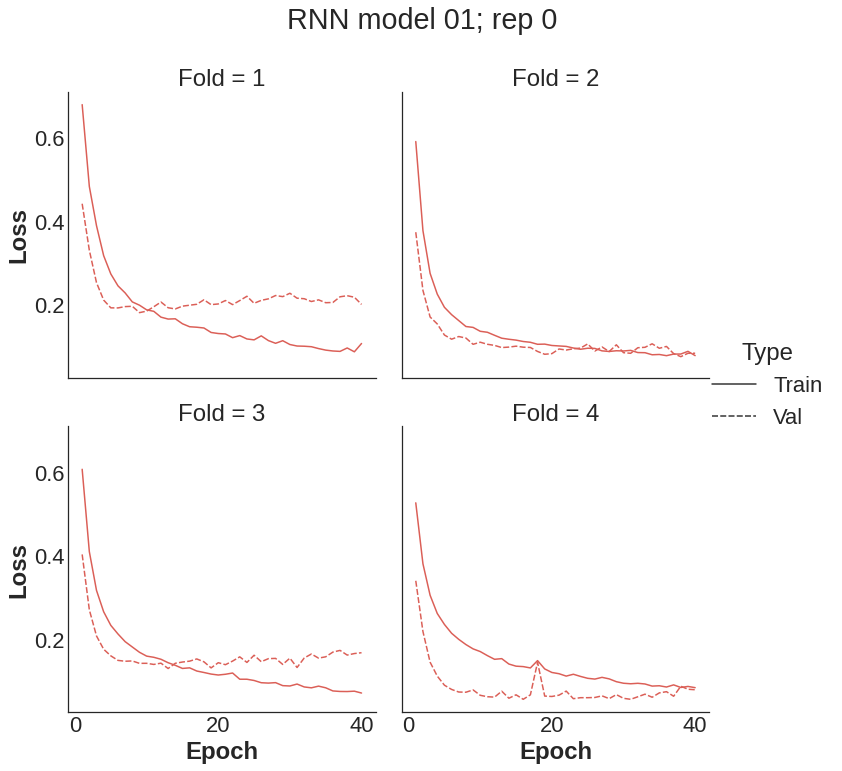

In [ ]:
figure_dir = '/content/drive/MyDrive/limb-position-EMG-Repo/figures/training_history/xsubject_joint_data/RNN'
results_dir = '/content/drive/MyDrive/limb-position-EMG-Repo/results_data/xsubject_joint_data/RNN/'
model_dir = '/content/drive/MyDrive/limb-position-EMG-Repo/model_data/xsubject_joint_data/RNN/'

In [ ]:
# Getting shape info
n_samples, n_features = feature_matrix_all.shape
n_outputs = np.unique(target_labels_all).size

#RNN training args - all other arguments are the same
verbose = 0
epochs = 40
batch_size = 5
nreps = 2

model_id = 1

np.random.seed(1)# Set seed for replicability

results_df = []

#rep = 0
# Repeat analysis over multiple repetitions to take into account stochasticity of experiment
for rep in range(nreps):
    print('Model %02 ; Repetition %i'%(model_id,rep))

    # Define model architecture
    # setting timestep dimension to None 
    model = get_rnn_model((None,n_features), n_outputs, n_grus = 24, n_dense_pre =  model_dict[model_id]['n_dense_pre'],\
                        n_dense_post =  model_dict[model_id]['n_dense_post'], activation = model_dict[model_id]['activation'],\
                        mask_value = -100)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # train and evaluate model
    train_f1, test_f1, train_history, trained_model = RNN_xsubject_joint_data(feature_matrix_all.T, target_labels_all, window_tstamps_all,\
                                            block_labels_all, model, n_splits = 4, verbose = verbose, epochs = epochs, batch_size = batch_size,\
                                            permute = False)

    results_df.append({'F1_score':train_f1,\
                    'Fold':np.arange(train_f1.size)+1,\
                    'Rep':[rep+1 for x in range(train_f1.size)],\
                    'Type':['Train' for x in range(train_f1.size)],\
                    'Shyffled':[False for x in range(train_f1.size)]
                    })

    results_df.append({'F1_score':test_f1,\
                    'Fold':np.arange(test_f1.size)+1,\
                    'Rep':[rep+1 for x in range(test_f1.size)],\
                    'Type':['Test' for x in range(test_f1.size)],\
                    'Shuffled':[False for x in range(test_f1.size)]
                    })

    fig_folder = os.path.join(figure_dir,'true_data')
    # summarize history for accuracy and loss - save to file
    fig,ax = plt.subplots(1,1,figsize=(11,5))
    ax.plot(train_history.history['accuracy'])
    ax.plot(train_history.history['val_accuracy'])
    #label axes
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend(['train', 'validation'], bbox_to_anchor=(1, 1), loc='upper left')
    #despine
    sns.despine(fig= plt.gcf(), left = False, right = True, top = True, bottom = True)
    fig.tight_layout() 
    fig.suptitle('RNN model %02d; rep %i'%(model_id,rep), y = 1.05)
    fig_fn = os.path.join(figure_directory,'rnn_model_%02d_rep_%i_acc.png'%(model_id,rep))
    fig.savefig(fig_fn,dpi = 300)
    plt.close()

    fig,ax = plt.subplots(1,1,figsize=(11,5))
    ax.plot(train_history.history['loss'])
    ax.plot(train_history.history['val_loss'])
    #label axes
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(['train', 'validation'], bbox_to_anchor=(1, 1), loc='upper left')
    #despine
    sns.despine(fig= plt.gcf(), left = False, right = True, top = True, bottom = True)
    fig.tight_layout()
    fig.suptitle('RNN model %02d; rep %i'%(model_id,rep), y = 1.05)
    fig_fn = os.path.join(figure_directory,'rnn_model_%02d_rep_%i_loss.png'%(model_id,rep))
    fig.savefig(fig_fn,dpi = 300)
    plt.close()

    #save trained model
    model_folder = os.path.join(model_dir, 'true_data')

    model_fn = os.path.join(model_folder, 'model_%02d_rep_%d.h5'%(model_id,rep))
    keras.models.save_model(trained_model, model_fn, save_format= 'h5')

    #repeat with shuffled data

    train_f1_perm, test_f1_perm, train_history, trained_model = RNN_xsubject_joint_data(feature_matrix_all.T, target_labels_all, window_tstamps_all,\
                                            block_labels_all, model, n_splits = 4, verbose = verbose, epochs = epochs, batch_size = batch_size,\
                                            permute = True)

    results_df.append({'F1_score':train_f1_perm,\
                    'Fold':np.arange(train_f1.train_f1_perm)+1,\
                    'Rep':[rep+1 for x in range(train_train_f1_permf1.size)],\
                    'Type':['Train' for x in range(train_f1_perm.size)],\
                    'Shuffled':[True for x in range(train_f1_perm.size)]
                    })

    results_df.append({'F1_score':test_f1_perm,\
                    'Fold':np.arange(test_f1_perm.size)+1,\
                    'Rep':[rep+1 for x in range(test_f1_perm.size)],\
                    'Type':['Test' for x in range(test_f1_perm.size)],\
                    'Shuffled':[True for x in range(test_f1_perm.size)]
                    })

    fig_folder = os.path.join(figure_dir,'permuted_data')
    # summarize history for accuracy and loss - save to file
    fig,ax = plt.subplots(1,1,figsize=(11,5))
    ax.plot(train_history.history['accuracy'])
    ax.plot(train_history.history['val_accuracy'])
    #label axes
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend(['train', 'validation'], bbox_to_anchor=(1, 1), loc='upper left')
    #despine
    sns.despine(fig= plt.gcf(), left = False, right = True, top = True, bottom = True)
    fig.tight_layout() 
    fig.suptitle('RNN model %02d; rep %i'%(model_id,rep), y = 1.05)
    fig_fn = os.path.join(figure_directory,'rnn_model_%02d_rep_%i_acc.png'%(model_id,rep))
    fig.savefig(fig_fn,dpi = 300)
    plt.close()

    fig,ax = plt.subplots(1,1,figsize=(11,5))
    ax.plot(train_history.history['loss'])
    ax.plot(train_history.history['val_loss'])
    #label axes
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(['train', 'validation'], bbox_to_anchor=(1, 1), loc='upper left')
    #despine
    sns.despine(fig= plt.gcf(), left = False, right = True, top = True, bottom = True)
    fig.tight_layout()
    fig.suptitle('RNN model %02d; rep %i'%(model_id,rep), y = 1.05)
    fig_fn = os.path.join(figure_directory,'rnn_model_%02d_rep_%i_loss.png'%(model_id,rep))
    fig.savefig(fig_fn,dpi = 300)
    plt.close()

    #save trained model
    model_folder = os.path.join(model_dir, 'permuted_data')

    model_fn = os.path.join(model_folder, 'model_%02d_rep_%d.h5'%(model_id,rep))
    keras.models.save_model(trained_model, model_fn, save_format= 'h5')

results_df = pd.concat(results_df,axis = 0)

Split Count: 1
(504, 45, 16) (504, 45, 6)
(168, 23, 16) (168, 23, 6)
Training Model
Evaluating Model
Split Count: 2
(504, 40, 16) (504, 40, 6)
(168, 45, 16) (168, 45, 6)
Training Model
Evaluating Model
Split Count: 3
(504, 45, 16) (504, 45, 6)
(168, 40, 16) (168, 40, 6)
Training Model
Evaluating Model
Split Count: 4
(504, 45, 16) (504, 45, 6)
(168, 32, 16) (168, 32, 6)
Training Model
Evaluating Model
Split Count: 1
(504, 45, 16) (504, 45, 6)
(168, 40, 16) (168, 40, 6)
Training Model
Evaluating Model
Split Count: 2
(504, 45, 16) (504, 45, 6)
(168, 27, 16) (168, 27, 6)
Training Model
Evaluating Model
Split Count: 3
(504, 45, 16) (504, 45, 6)
(168, 22, 16) (168, 22, 6)
Training Model
Evaluating Model
Split Count: 4
(504, 40, 16) (504, 40, 6)
(168, 45, 16) (168, 45, 6)
Training Model
Evaluating Model


AttributeError: ignored

In [ ]:
print(train_f1_perm,test_f1_perm)

[0.31863318 0.41820374 0.55027615 0.58676484] [0.20427204 0.22272731 0.2475416  0.40485861]


In [ ]:
print(train_f1,test_f1)

[0.95190895 0.96781533 0.97217103 0.98515268] [0.82258447 0.84888875 0.85705192 0.90402446]


In [ ]:


#save results

In [ ]:
#create training scaler

In [ ]:
# results_fn = 'subject_%02d_across_subject_results.h5'%(src_subject_id)